<a href="https://colab.research.google.com/github/Maanaav/AutoEncoder-using-PyTorch/blob/main/AutoEncoder_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/mnist_dataset.csv')

In [ ]:
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Converting 1 image into noisy image

In [ ]:
image = data.iloc[8] # select image at index 18
image = np.array(image).astype('float32')

# 784 pixel convert to 28x28
image = np.reshape(image, (28,28)) # reshape
image = image / 255 # scale between 0 and 1

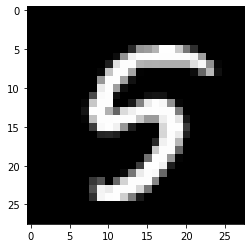

In [ ]:
plt.imshow(image, cmap = ('gray'))

In [ ]:
noisy_image = image + 0.2 * np.random.randn(*image.shape) # convert to noisy image with 0.2 noise spectre
noisy_image = np.clip(noisy_image, 0, 1) # clip the range b/w 0 and 1

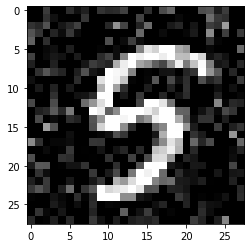

In [ ]:
plt.imshow(noisy_image, cmap='gray')

Functions

In [ ]:
def show_image(noisy_image,org_image,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('noisy_image')
        ax1.imshow(noisy_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('original_image')
        ax2.imshow(org_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('denoised_image')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        
class ToTensorForAE(object): # custom transform which converts numpy, PIL image to otch tensor and also it will convert image with (height, width, channel) to (channel, height, width) as per pytorch model input convention
    
    def __call__(self,sample):
        
        images,labels = sample
        
        images = images.transpose((2,0,1))
        labels = labels.transpose((2,0,1))
        
        return torch.from_numpy(images).float(),torch.from_numpy(labels).float()

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class MNIST_AE(Dataset):
  def __init__(self, csv_file, noise_factor = 0.2, transform = None):
    self.data = pd.read_csv(csv_file)
    self.noise_factor = noise_factor
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    img = self.data.iloc[index]
    img = np.array(img)
    img = np.reshape(img, (28, 28, 1)) # we are using grayscale images so we mention the channel as 1
    img = img / 255 # scale the image

    noisy_img = img + np.random.randn(*img.shape) * self.noise_factor
    noisy_img = np.clip(noisy_img, 0, 1)

    sample = (noisy_img, img)
    if self.transform:
      sample = self.transform(sample)

      return sample

In [ ]:
trainset = MNIST_AE('/content/drive/MyDrive/Colab Notebooks/Data/mnist_dataset.csv', transform = ToTensorForAE()) # custom data set

In [ ]:
print(f"Size of trainset: {len(trainset)}")

Size of trainset: 42000


In [ ]:
noisy_image, org_image = trainset[8]

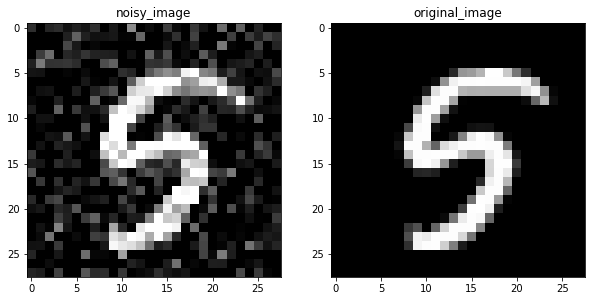

In [ ]:
show_image(noisy_image, org_image)

Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainLoader = DataLoader(trainset, batch_size = 16, shuffle = True)

In [ ]:
dataIter = iter(trainLoader)
noisy_img, org_img = dataIter.next()

print(f"Shape of loading one batch: {noisy_img.shape}")
print(f"Total number of batches: {len(trainLoader)}")
print(f"Total number of examples: {len(trainLoader.dataset)}")

Shape of loading one batch: torch.Size([16, 1, 28, 28])
Total number of batches: 2625
Total number of examples: 42000


Create AutoEncoder Model

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
def Encoder():
  enc = nn.Sequential(
      nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3, 3), padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2, 2)),

      nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3), padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size = (2, 2)),
  ) # encoder network
  return enc

In [ ]:
def Decoder():
  dec = nn.Sequential(
      # Convolutional transport layer
      nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = (2, 2), stride = 2),
      nn.ReLU(), # activation layer

      nn.ConvTranspose2d(in_channels = 16, out_channels = 1, kernel_size = (2, 2), stride = 2),
      nn.Sigmoid(), # activation layer
  )# decoder network
  return dec

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, inp_imgs):
    encoder_out = self.encoder(inp_imgs)
    decoder_out = self.decoder(encoder_out)

    return decoder_out

model = AutoEncoder()
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [ ]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train AutoEncoder

In [ ]:
from tqdm import tqdm # use it for loop progression

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
epochs = 10

In [ ]:
for i in range(epochs):
  train_loss = 0.0

  model.train()
  for batch in trainLoader:
    noisy_img, org_img = batch
    
    denoised_img = model(noisy_img)
    loss = criterion(denoised_img, org_img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  avg_train_loss = train_loss / len(trainLoader)
  print(f"Epoch: {i+1} Train Loss: {avg_train_loss}")

Epoch: 1 Train Loss: 0.005278282564754287
Epoch: 2 Train Loss: 0.005017501302063465
Epoch: 3 Train Loss: 0.004853600600202169
Epoch: 4 Train Loss: 0.0047408730801904485
Epoch: 5 Train Loss: 0.004665308833122253
Epoch: 6 Train Loss: 0.004612315609252879
Epoch: 7 Train Loss: 0.004564822538711486
Epoch: 8 Train Loss: 0.0045267202875443864
Epoch: 9 Train Loss: 0.004499097061920024
Epoch: 10 Train Loss: 0.004462022388087851


Plot results

torch.Size([1, 28, 28])


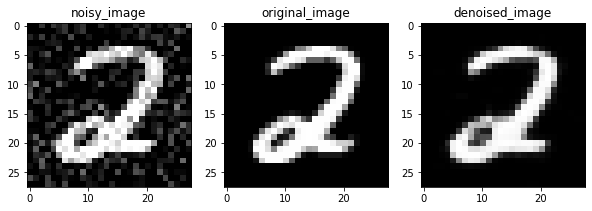

In [ ]:
model.eval()
with torch.no_grad():
  dataIter = iter(trainLoader)
  sample = dataIter.next()

  noisy_img, org_img = sample # 1 batch contains 16 example
  index = 8

  denoised_img = model(noisy_img[index].unsqueeze(0)) #(c, h,w) -> (bs, c, h, w), bs = 1
  print(denoised_img.squeeze(0).shape) # squeeze to discard batch size

  show_image(noisy_img[index], org_img[index], denoised_img.squeeze(0))